# ***Banana Republic Bus Demand*** 

## TASK: 
Forecasting bus demand in Banana Republic municipalities. The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you. 

The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. 

The dataset format is as follows (comma separated values): MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. 

There are 10 municipalities (ids from 0 to 9), and two measurements for an hour. The committee asks you to forecast the hourly bus usages for next week for each municipality. 

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

In [3]:
df = pd.read_csv("/home/ahmet/Desktop/AI/DATA SETS/municip/municipality_bus_utilization.csv")

In [4]:
df.head()

timestamp  municipality_id  usage  total_capacity
0  2017-06-04 07:59:42                9    454            1332
1  2017-06-04 07:59:42                8    556            2947
2  2017-06-04 07:59:42                4   1090            3893
3  2017-06-04 07:59:42                0    204            2813
4  2017-06-04 07:59:42                7    718            2019

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


I have observed a time lag in measurements, adding 10 mins to each measurement time helps to achieve more uniform measurement counts for each hour. 

In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["timestamp"] = df["timestamp"].apply(lambda x: x + pd.Timedelta(minutes=10))
df["hour"] = df["timestamp"].dt.hour
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day

In [7]:
df.head()

timestamp  municipality_id  usage  total_capacity  hour  month  \
0 2017-06-04 08:09:42                9    454            1332     8      6   
1 2017-06-04 08:09:42                8    556            2947     8      6   
2 2017-06-04 08:09:42                4   1090            3893     8      6   
3 2017-06-04 08:09:42                0    204            2813     8      6   
4 2017-06-04 08:09:42                7    718            2019     8      6   

   day  
0    4  
1    4  
2    4  
3    4  
4    4

In [381]:
def hour_max (d, ts):
    "returns the max usage in a given timestamp"

    max_usage = d[(d["hour"]==ts.hour)&(d["day"]==ts.day)&(d["month"]==ts.month)]["usage"].max()
    return max_usage

In [382]:
def munip_df(id):
    "returns a seperate dataframe of the municipality of input id"
    
    df_id = df[df["municipality_id"]==id]
    df_id["max"] = df_id["timestamp"].apply(lambda x: hour_max(df_id, x))
    df_id.drop_duplicates(subset=["total_capacity","hour","month","day", "max"], inplace=True)
    df_id["timestamp"] = df_id["timestamp"].dt.floor(freq="H")
    df_id=df_id[["timestamp","max"]]
    df_id.set_index("timestamp",inplace=True)
    return df_id    

In [383]:
def shift_df(dataframe, days, hours):
    "shifts the input dataframe by input days and hours"
    
    shifts = np.arange(1,days).astype(int)
    shifts = shifts * hours
    shifted_data = {"shifted_{}_hours".format(s): dataframe.shift(s) for s in shifts}
    shifted_data = {k:v["max"] for (k, v) in shifted_data.items()}
    shifted_df = pd.DataFrame(shifted_data)
    shifted_df = shifted_df.fillna(np.nanmedian(shifted_df))
    return shifted_df

In [384]:
def split_train_test(dataframe, shifted_df):
    "splits input dataframes to train and test data"
    
    X_train = shifted_df[:-135]
    y_train = dataframe[:-135]
    X_test = shifted_df[-135:]
    y_test = dataframe[-135:]
    return X_train, X_test, y_train, y_test   

In [13]:
def train_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

In [385]:
def plot_loss(y_test, predictions):
    "plots the residuals"
    
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(y_test["max"].values, color='k')
    ax.plot(predictions, color='r')
    ax.set_title("municipality_{}".format(i))
    plt.show()

In [386]:
def percent_change(data):
    "returns the percent change in given data points"
    
    previous_values = data[:-1]
    last_value = data[-1]
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

In [387]:
def compare_models(list1, list2):
    "compares two list of scores and prints the differences"
    
    for mun, (score1, score2) in enumerate(zip(list1, list2)):
        if score1>score2:
            dif = score1-score2
            print("model_1 fit better to municipality_{}, by {}".format(mun, dif))
        elif score2>score1:
            dif = score2 - score1 
            print("model_2 fit better to municipality_{}, by {}".format(mun,dif))
        else:
            print("same")

In [388]:
def evaluate(model, shift, roll, func=percent_change):
    """ shifts the data of each municipality by input day, 
    rolls each data with input window range and 
    aggregates input function to each window,
    splits the data, trains input model with each training data,
    predicts withs each test data, finally calculates and returns
    the list of r2 scores    
    """
    scores = []
    for i in range(10):
        data=munip_df(i)
        data = data.rolling(roll,min_periods=1).aggregate(func)
        data.fillna(method="backfill",inplace=True)
        shifted_data = shift_df(data, 9, shift)
        X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
        predictions = train_predict(model, X_train,y_train,X_test)
        score = r2_score(y_test, predictions)
        scores.append(score)
    return scores

## 1) Simple Model

Simple model with Linear Regression. Total r2 score for 10 municipalities is **3.2** (over 10, since there are 10 municipalities) which is not satisfactory. 

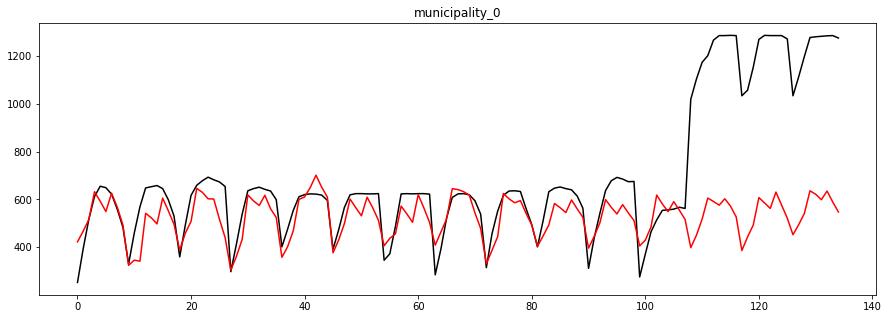

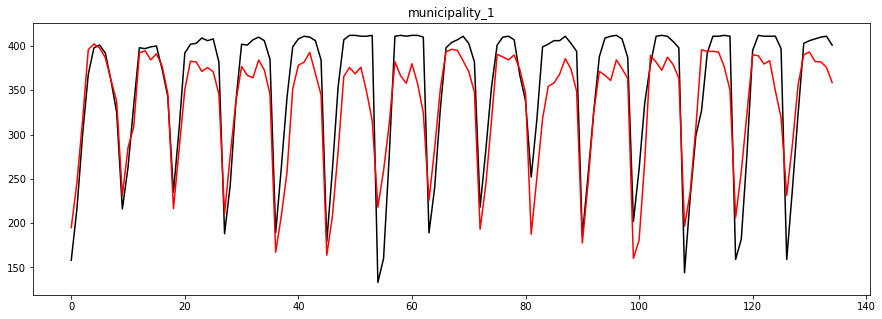

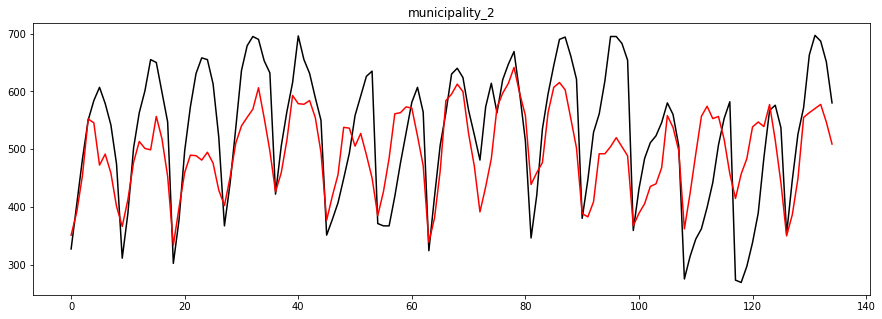

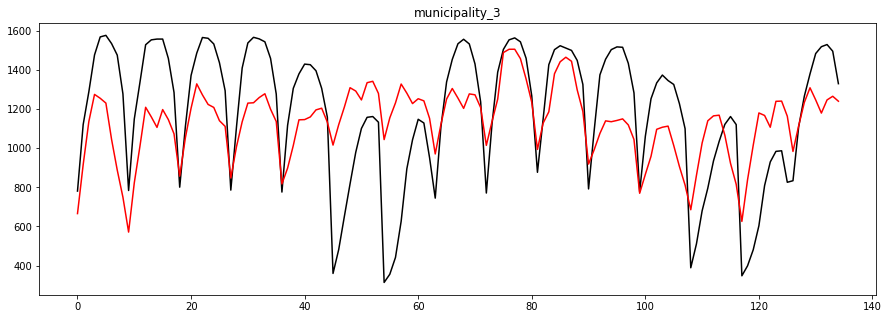

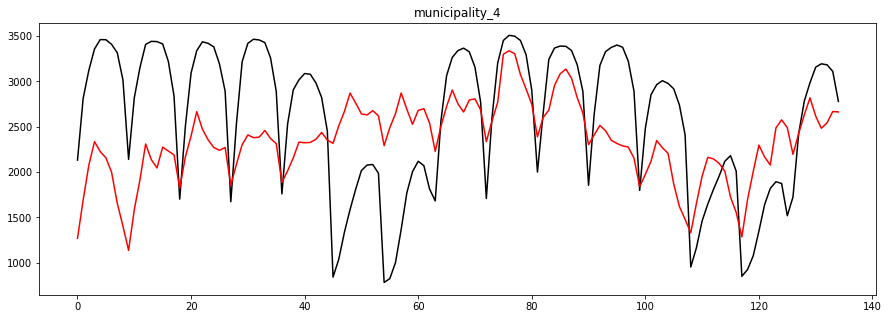

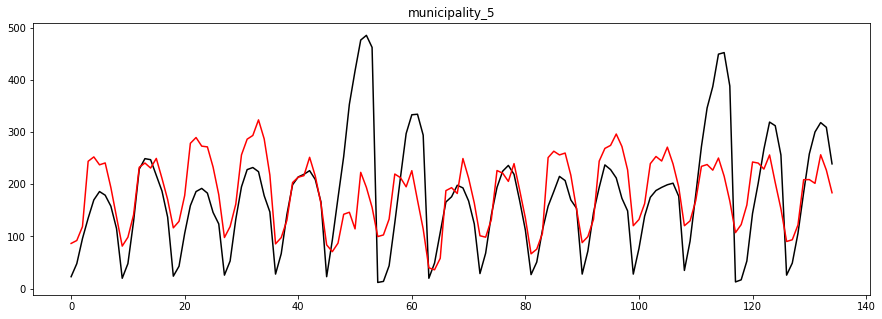

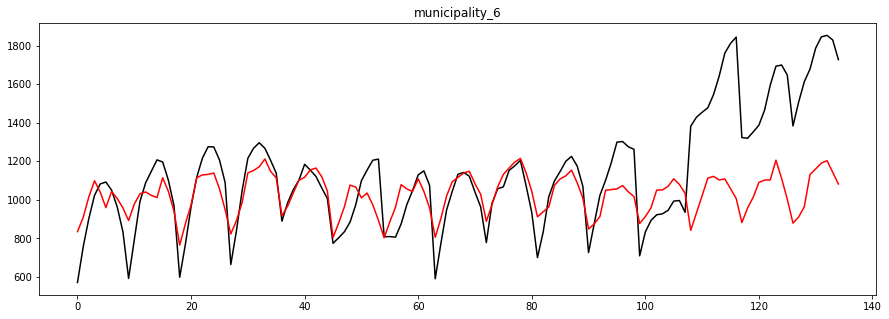

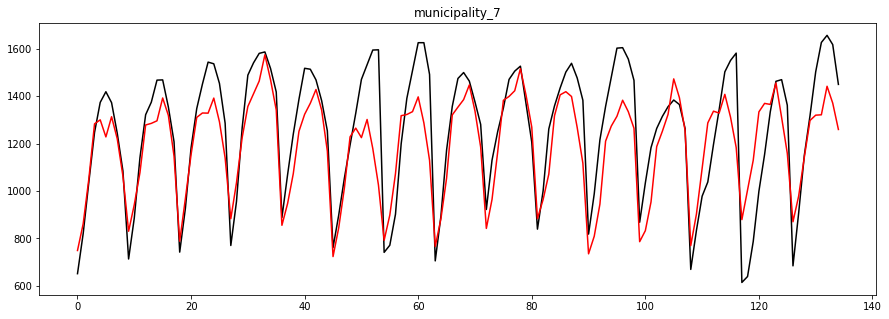

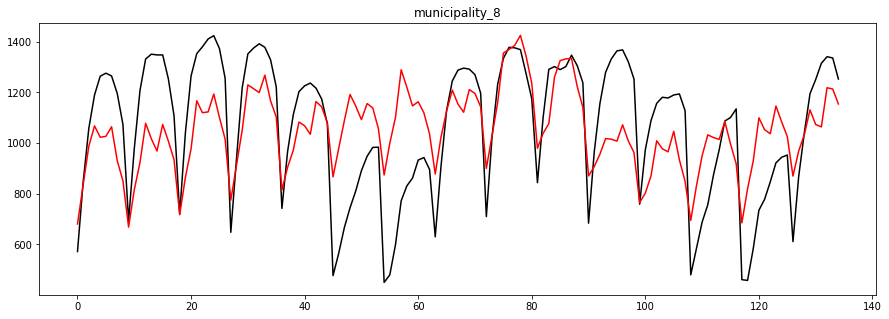

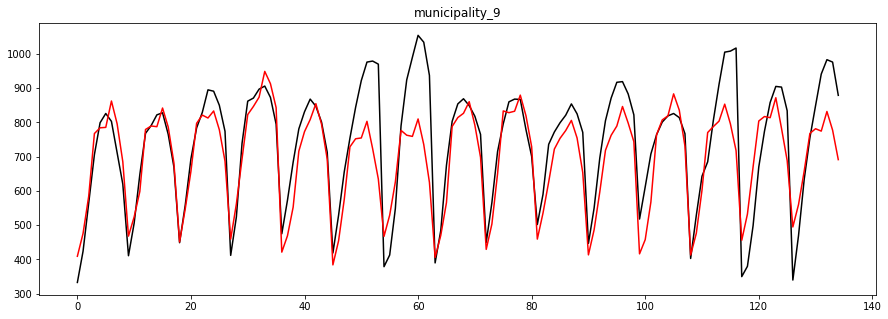

In [181]:
model = LinearRegression() 
r2_lr = []
for i in range(10):
    data=munip_df(i)
    shifted_data = shift_df(data, 9, 15)
    X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
    predictions = train_predict(model, X_train,y_train,X_test)
    score = r2_score(y_test, predictions)
    r2_lr.append(score)
    plot_loss(y_test, predictions)

In [182]:
total_score_lr = sum(r2_lr)
total_score_lr

3.1981988741190275

## 2) Complex Model

## 2-1) Ridge

A stronger model with smoothened data. Data is rolled by a window range 2 and transformed with the percent difference within the window. Also used Ridge algorithm to distribute the weights more evenly. Score is more satisfactory compared to simple model "**7.12/10**"

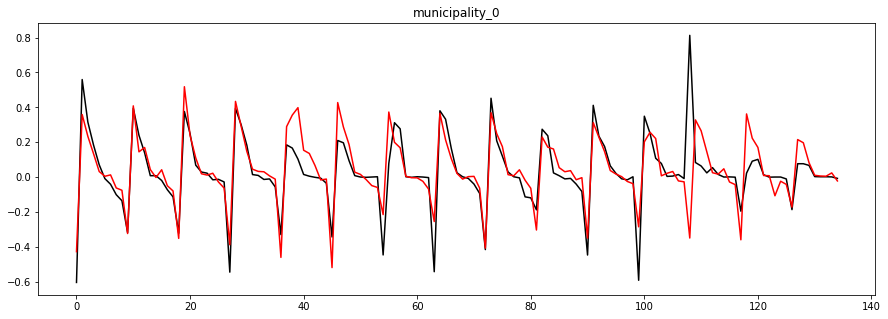

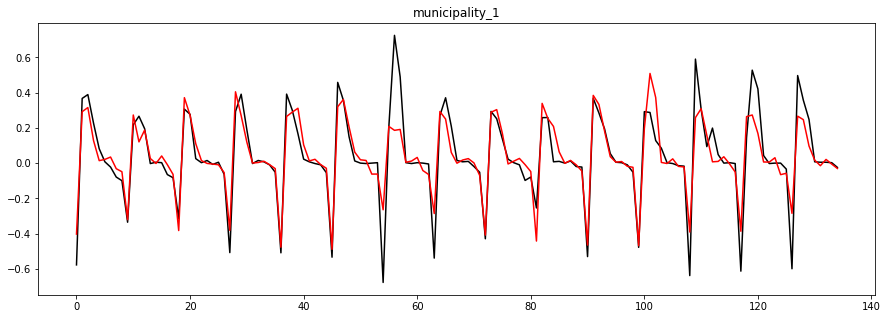

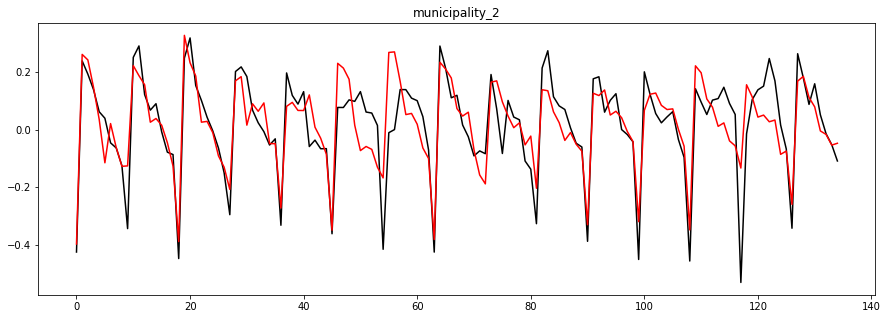

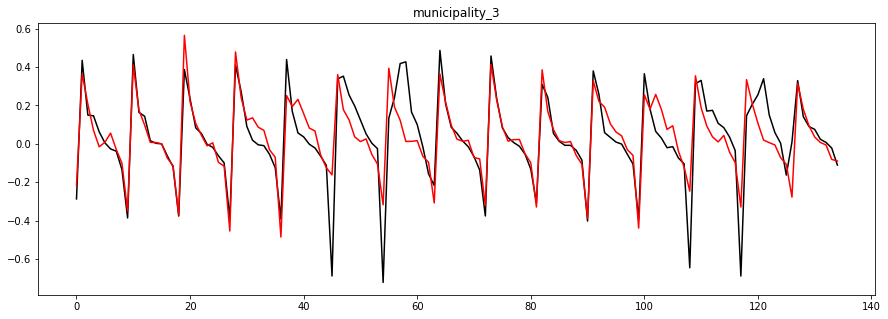

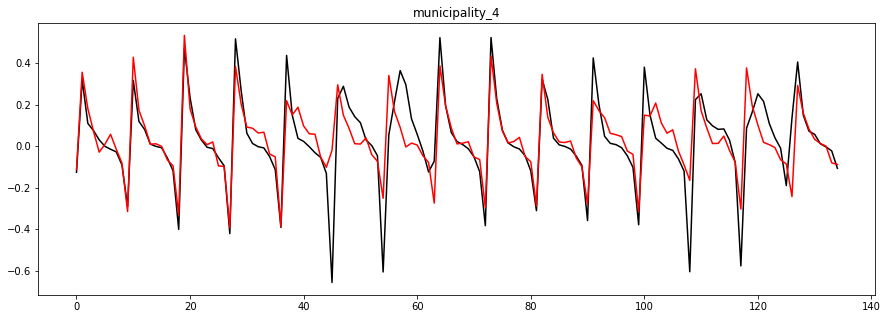

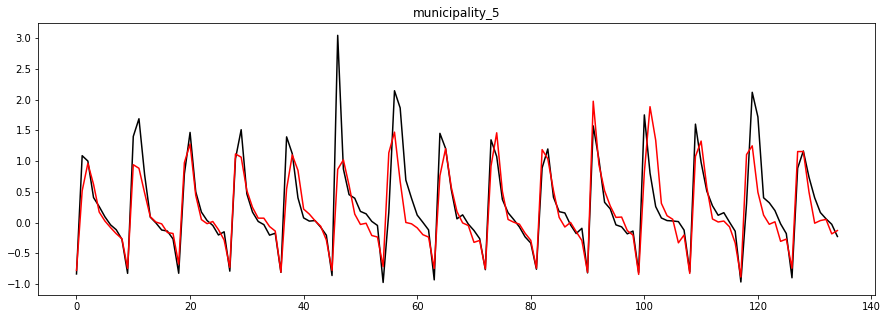

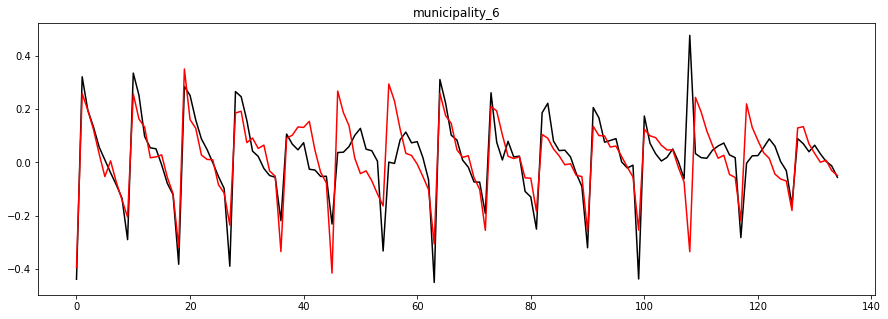

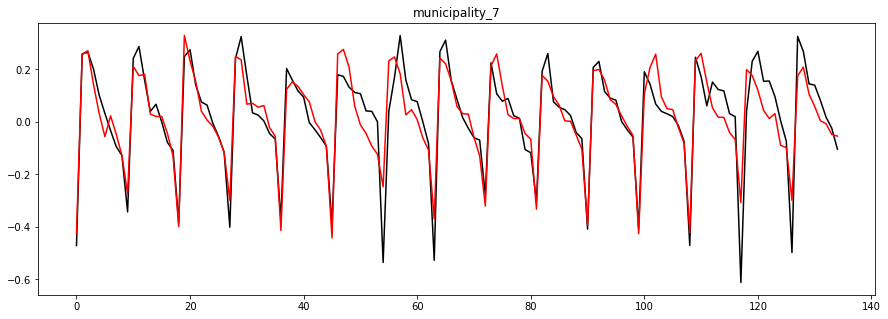

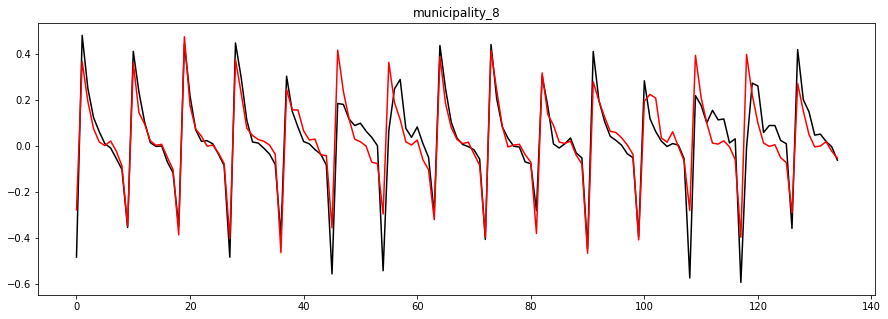

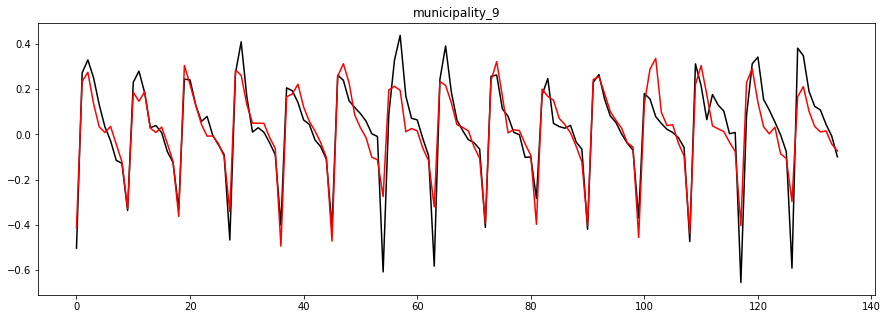

In [231]:
model = Ridge() 
scores_ridge_15 = []
for i in range(10):
    data=munip_df(i)
    data = data.rolling(2,min_periods=1).aggregate(percent_change)
    data.fillna(method="backfill",inplace=True)
    shifted_data = shift_df(data, 9, 15)
    X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
    predictions = train_predict(model, X_train,y_train,X_test)
    score = r2_score(y_test, predictions)
    scores_ridge_15.append(score)
    plot_loss(y_test, predictions)

In [377]:
scores_ridge_15

[0.5400020194023614,
 0.7986246574402875,
 0.6929446680540553,
 0.7248644787387719,
 0.6735338184293416,
 0.7112348193994458,
 0.4912891162483186,
 0.8341741935351443,
 0.8280539617429934,
 0.8263988756417701]

In [378]:
sum(scores_ridge_15)

7.12112060863249

As seen from the graphs model captures the majority of the peaks, with some delay in some cases. That is mainly caused because of the lags in the data itself. There are 1 measurements for some days and 4 measurements in 1 day. 

Those data shall be further analyzed by more domain expertise. Wrangling those inconsistencies without a porper root cause analysis does not make sense and will be nothing more than a simple lb probbing.

Some further feature extraction techniques can be used to smoothen the peaks by removing the outliers of the data but since those data is observed numbers or usage, it does not make sense to remove them. 

Those operations may help to get better results with test data but will lead us to poor generalization in further use of the model.

So I believe best method to improve performance is the hyperparameter tuning and model sellection.

In [238]:
# shifting 21 days and window of 2 hours with Ridge
scores_ridge_21 = evaluate(Ridge(), 21, 2)

In [376]:
scores_ridge_21

[0.4175804060659083,
 0.8510655319192846,
 0.6837490386586271,
 0.7580439359365805,
 0.7161843941886317,
 0.760397299775239,
 0.45932588946141484,
 0.8527306002628277,
 0.8468320739452873,
 0.8705845408703693]

In [239]:
sum(scores_ridge_21)

7.216493711084169

In [240]:
compare_models(scores_ridge_15,scores_ridge_21)

model_1 fit better to municipality_0, by 0.12242161333645307
model_2 fit better to municipality_1, by 0.052440874478997035
model_1 fit better to municipality_2, by 0.009195629395428173
model_2 fit better to municipality_3, by 0.03317945719780857
model_2 fit better to municipality_4, by 0.0426505757592901
model_2 fit better to municipality_5, by 0.04916248037579318
model_1 fit better to municipality_6, by 0.031963226786903776
model_2 fit better to municipality_7, by 0.018556406727683328
model_2 fit better to municipality_8, by 0.018778112202293862
model_2 fit better to municipality_9, by 0.044185665228599236


In [241]:
# Combine two models 
combined_scores = [i if i>k else k for i,k in zip(scores_ridge_15,scores_ridge_21)]

In [245]:
sum(combined_scores)

7.380074180602955

## 2-2) ENSEBLE ALGORITHMS

In [246]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

In [319]:
ADA = AdaBoostRegressor(learning_rate=0.1)
ETR = ExtraTreesRegressor()
BAG = BaggingRegressor(base_estimator=ETR)
GBR = GradientBoostingRegressor()
RFR = RandomForestRegressor()

### AdaBoostRegressor

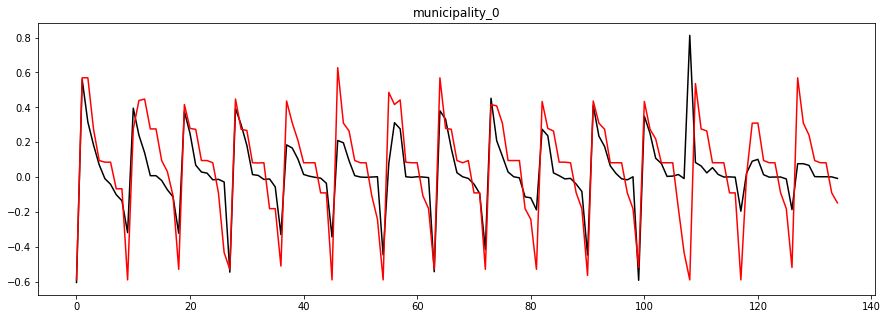

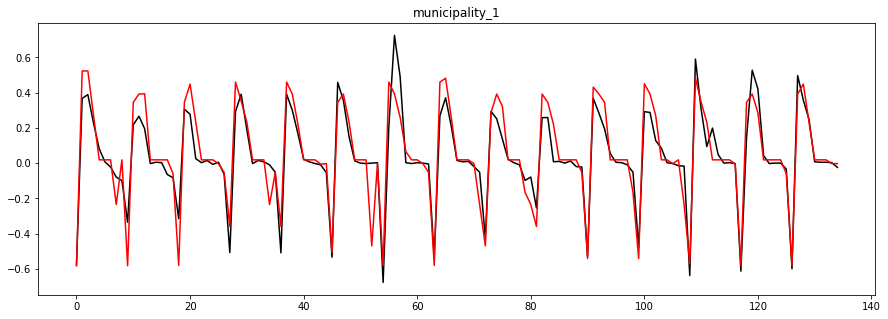

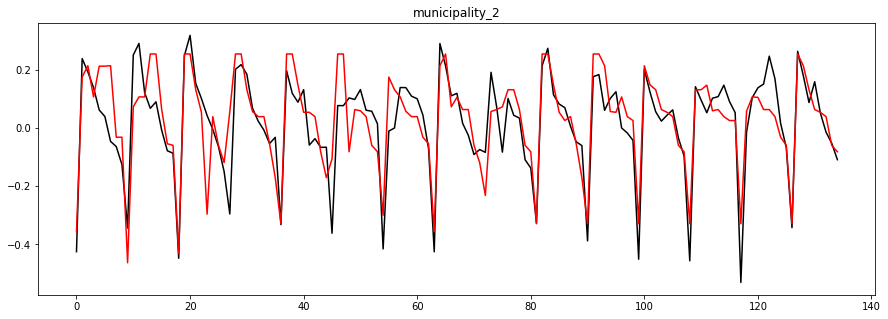

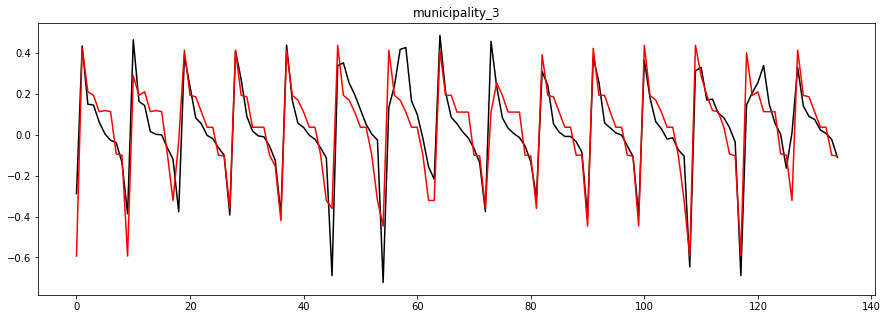

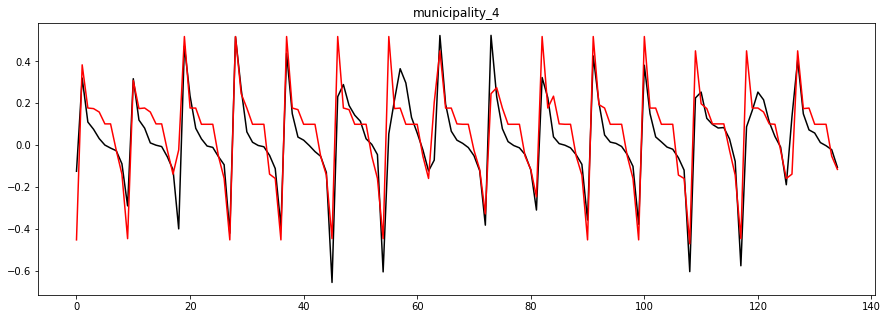

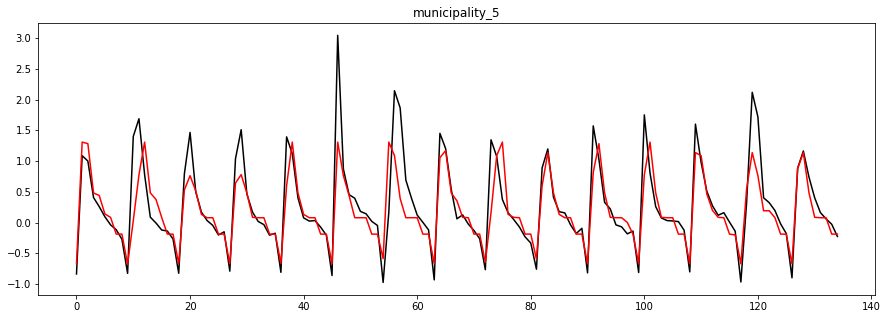

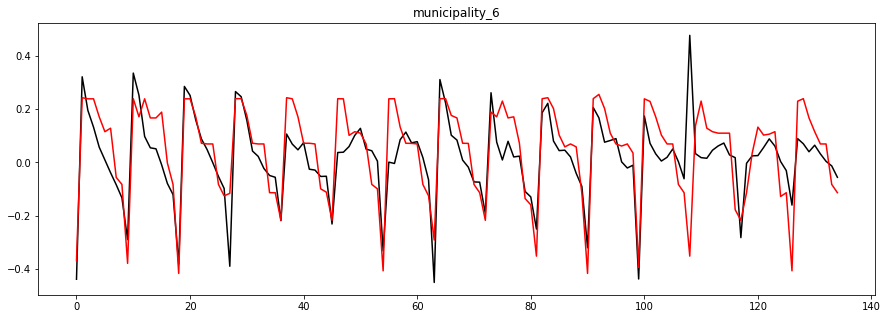

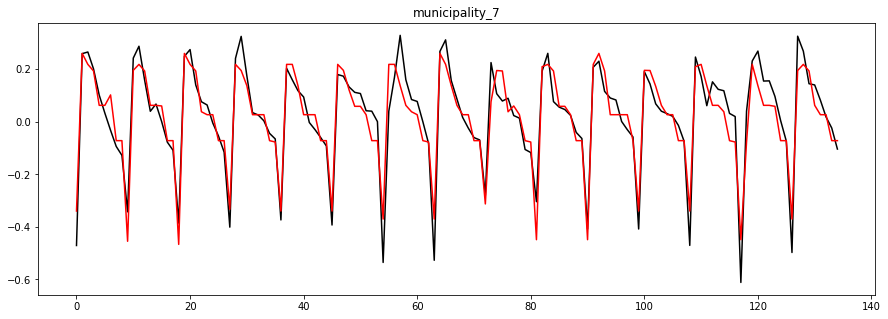

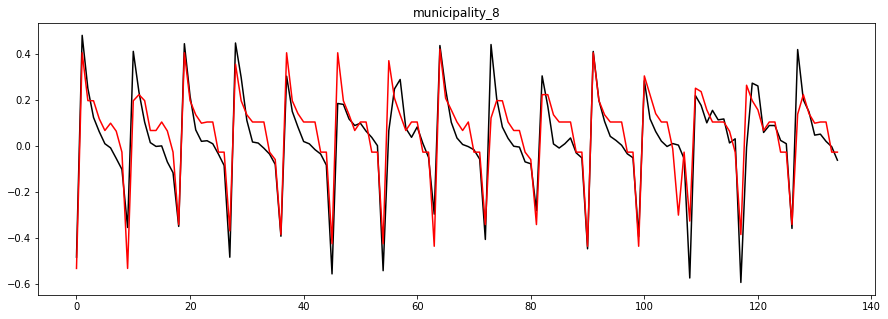

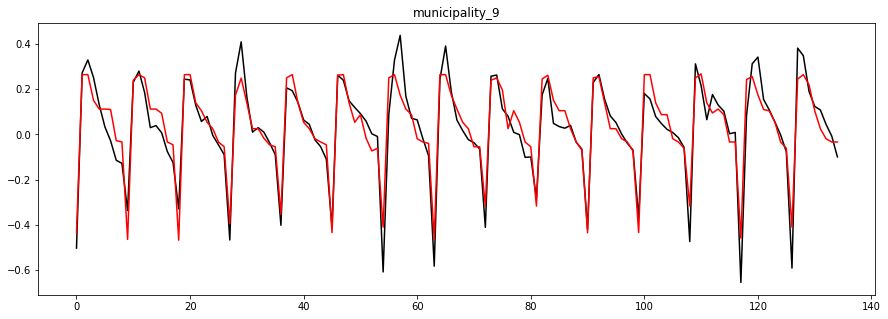

In [390]:
scores_ADA = []
for i in range(10):
    data=munip_df(i)
    data = data.rolling(2,min_periods=1).aggregate(percent_change)
    data.fillna(method="backfill",inplace=True)
    shifted_data = shift_df(data, 9, 21)
    X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
    predictions = train_predict(ADA, X_train,y_train.values.ravel(),X_test)
    score = r2_score(y_test, predictions)
    scores_ADA.append(score)
    plot_loss(y_test, predictions)

In [391]:
scores_ADA

[0.04139474864964321,
 0.8141268851297324,
 0.6837598436507182,
 0.7333032933343429,
 0.6850094267769149,
 0.6910935172944319,
 0.36892510007737567,
 0.8775854630439947,
 0.7913536770683148,
 0.8848925789373346]

In [332]:
sum(scores_ADA)

6.470740562782579

### ExtraTreesRegressor

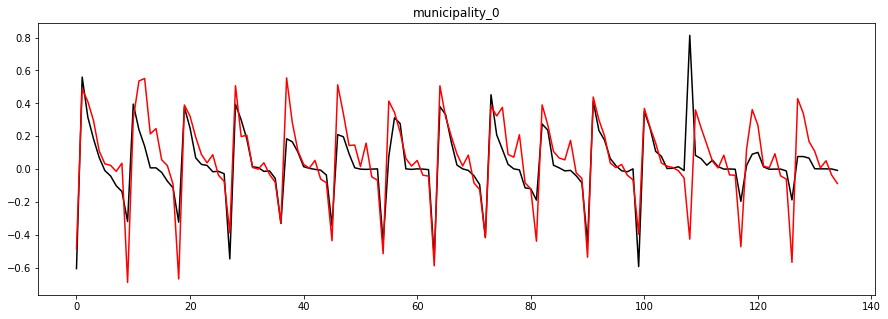

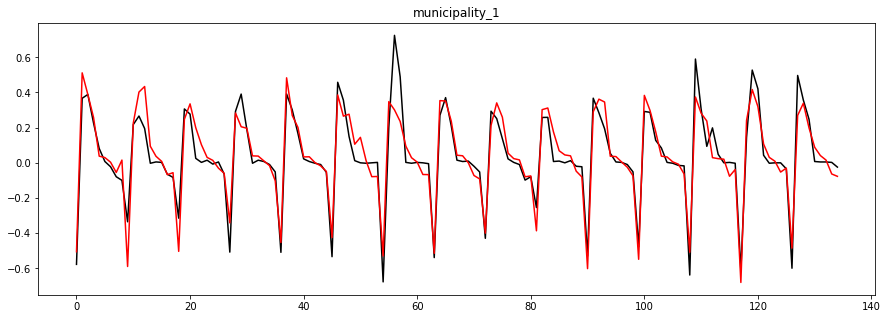

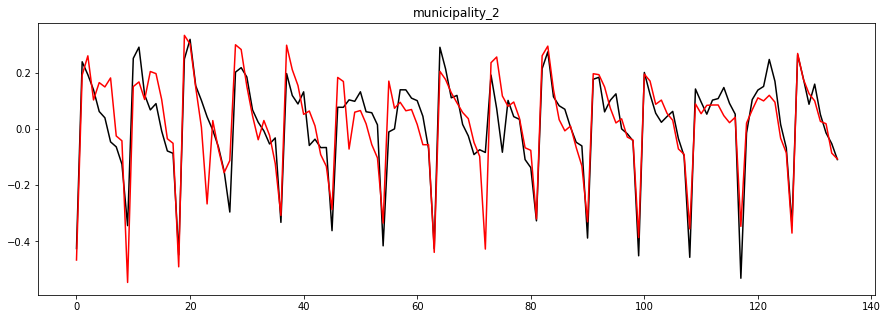

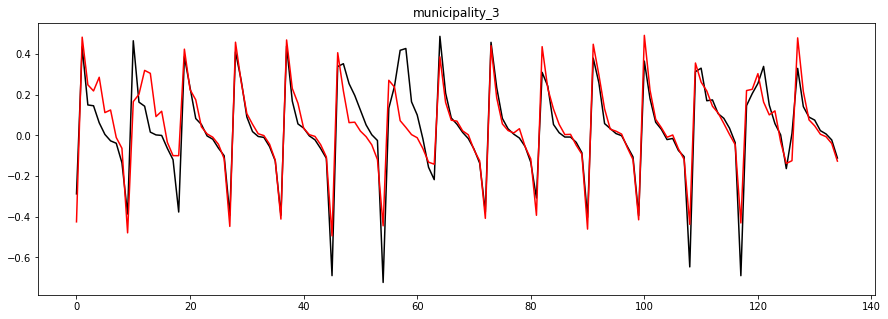

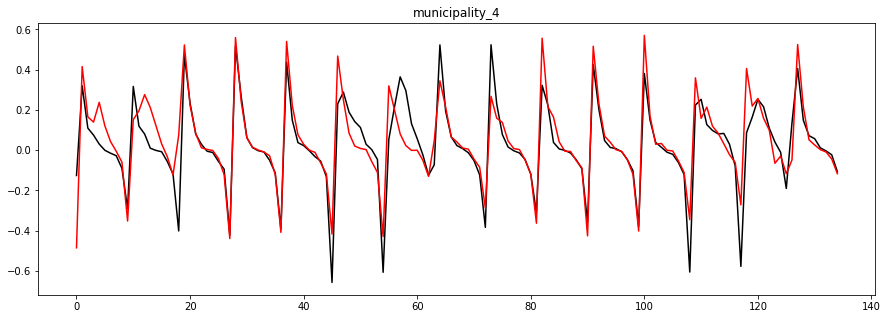

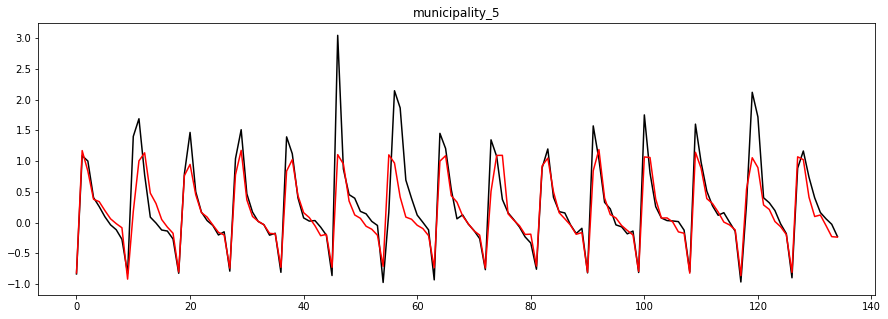

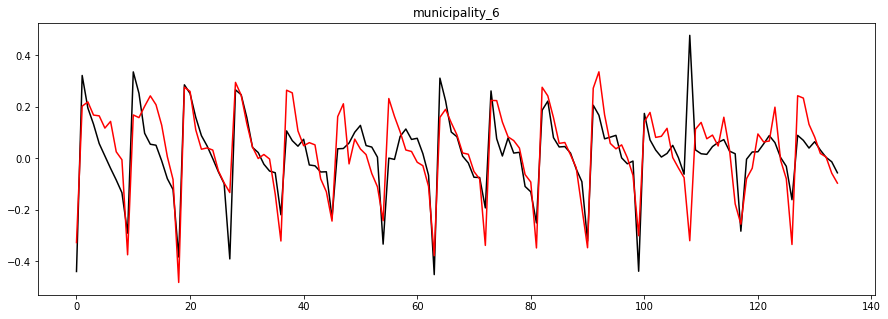

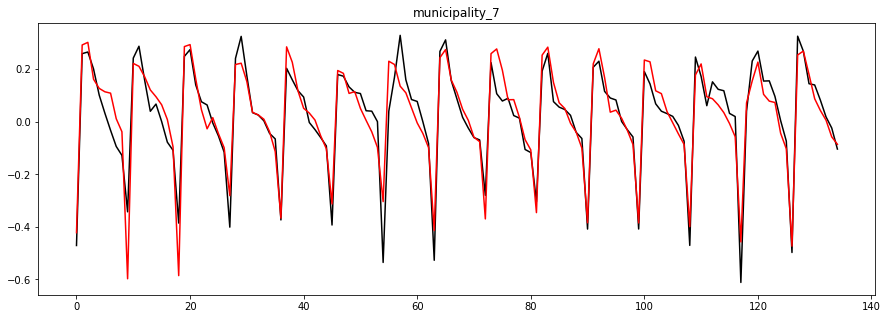

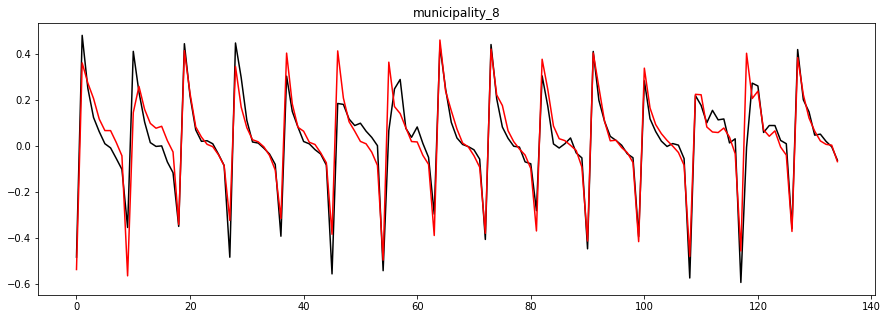

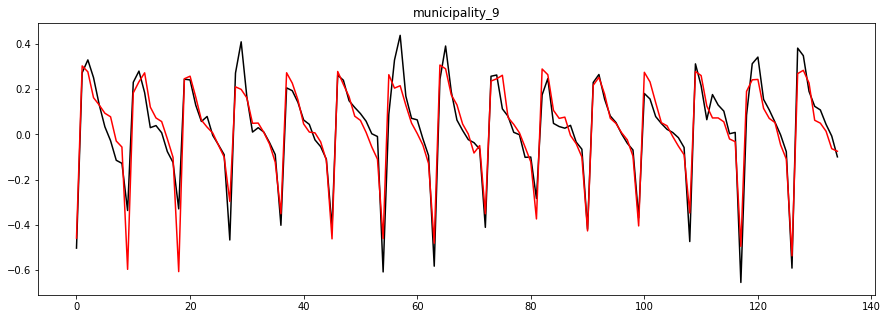

In [393]:
scores_ET = []
for i in range(10):
    data=munip_df(i)
    data = data.rolling(2,min_periods=1).aggregate(percent_change)
    data.fillna(method="backfill",inplace=True)
    shifted_data = shift_df(data, 9, 21)
    X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
    predictions = train_predict(ExtraTreesRegressor(), X_train,y_train.values.ravel(),X_test)
    score = r2_score(y_test, predictions)
    scores_ET.append(score)
    plot_loss(y_test, predictions)

In [308]:
scores_ET

[0.31140043985642696,
 0.8730112716811671,
 0.7606575940841028,
 0.7945043744485137,
 0.7288700726901411,
 0.736950853797934,
 0.447649104110851,
 0.8760640997378446,
 0.8634448821801003,
 0.8882763321565481]

In [309]:
sum(scores_ET)

7.28082902474363

### BaggingRegressor

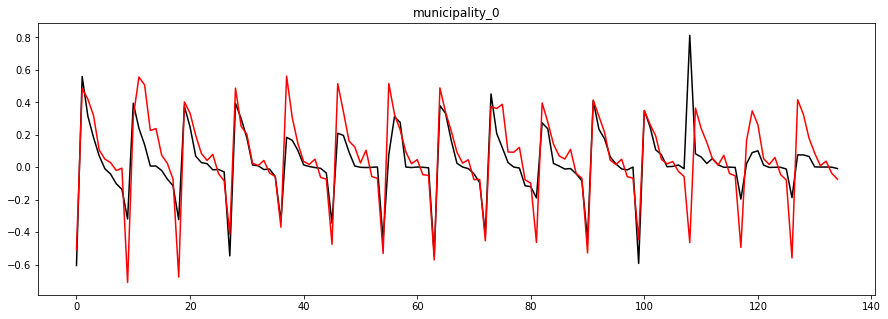

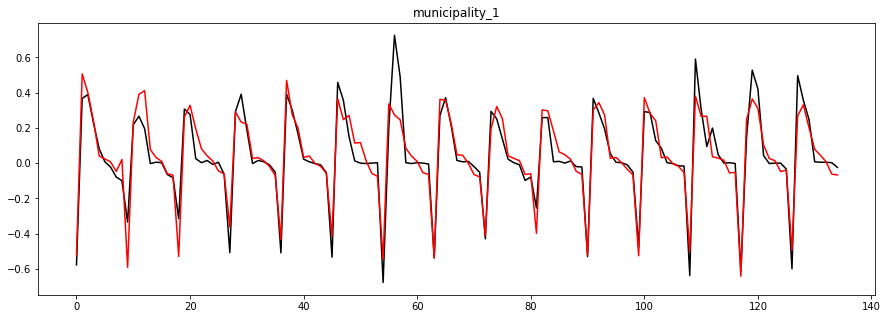

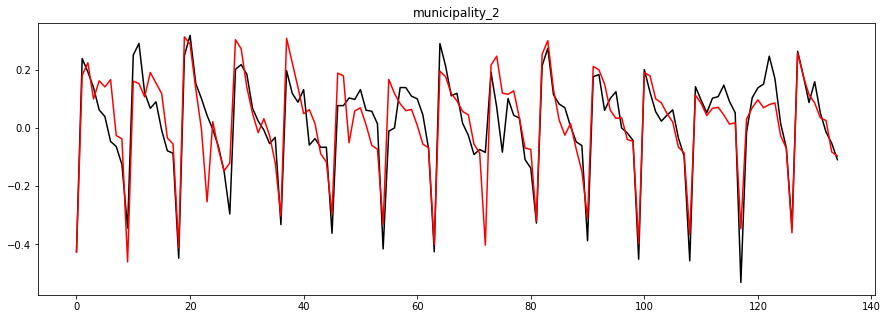

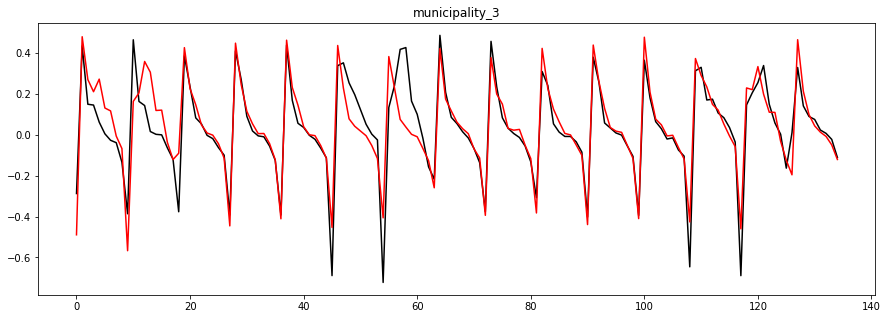

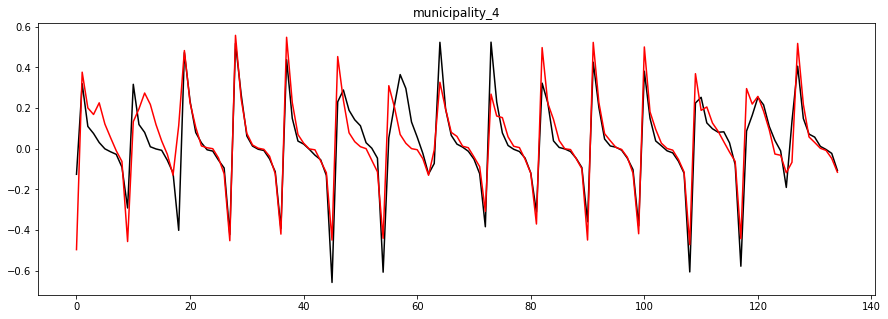

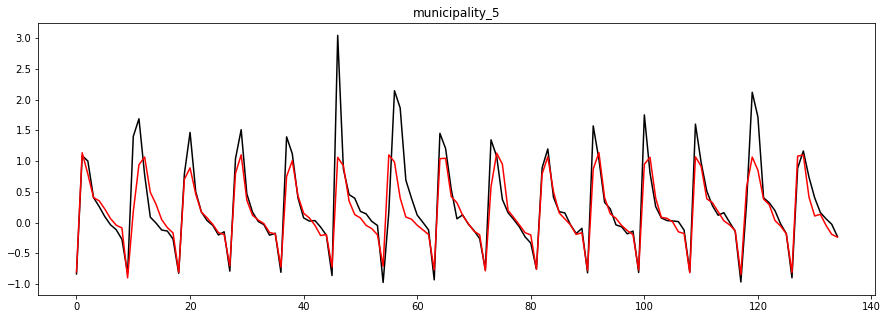

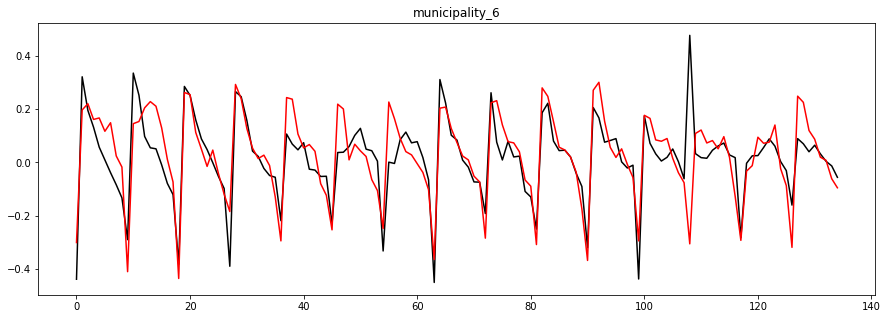

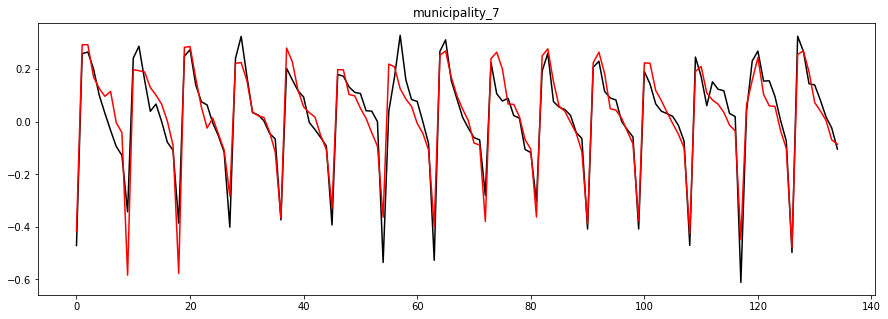

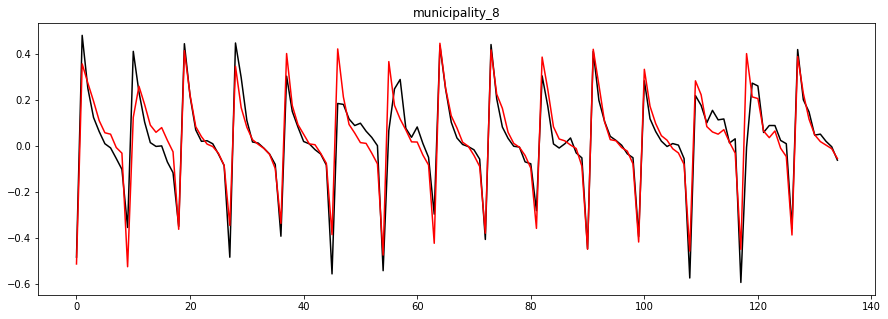

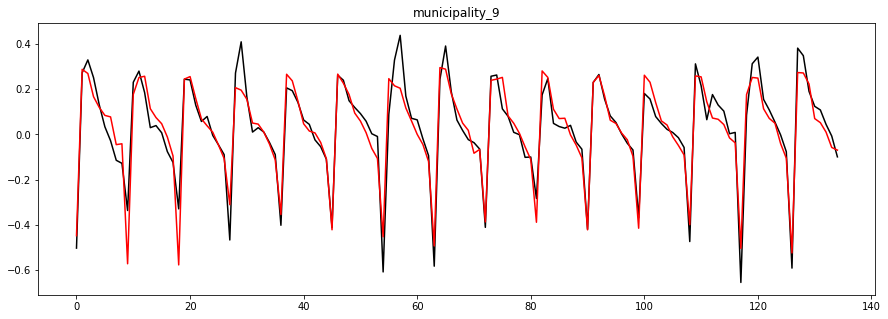

In [313]:
scores_BAG = []
for i in range(10):
    data=munip_df(i)
    data = data.rolling(2,min_periods=1).aggregate(percent_change)
    data.fillna(method="backfill",inplace=True)
    shifted_data = shift_df(data, 9, 21)
    X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
    predictions = train_predict(BAG, X_train,y_train.values.ravel(),X_test)
    score = r2_score(y_test, predictions)
    scores_BAG.append(score)
    plot_loss(y_test, predictions)

In [314]:
scores_BAG

[0.3036232293814435,
 0.8682191507752096,
 0.7714157483937143,
 0.7916352740812986,
 0.7530679561030459,
 0.7458457276131168,
 0.4964980843672122,
 0.8870907066604087,
 0.862177610154089,
 0.8982382034734706]

In [315]:
sum(scores_BAG)

7.377811691003011

### GradientBoostingRegressor

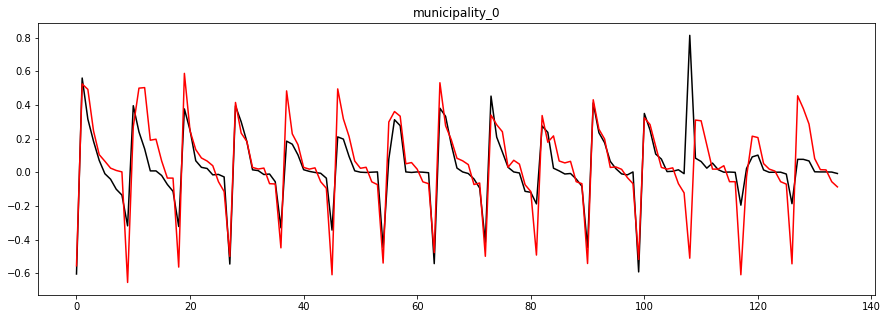

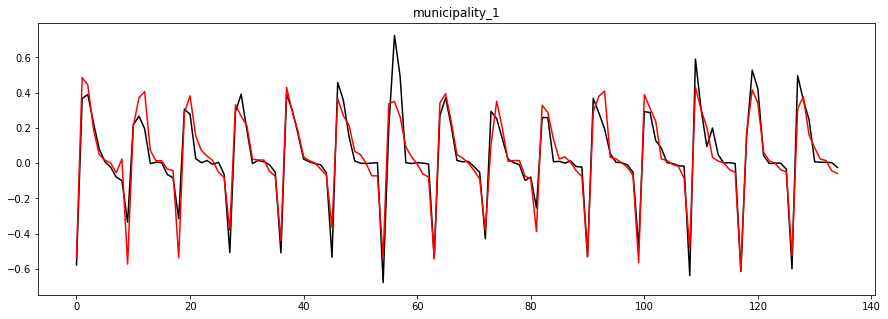

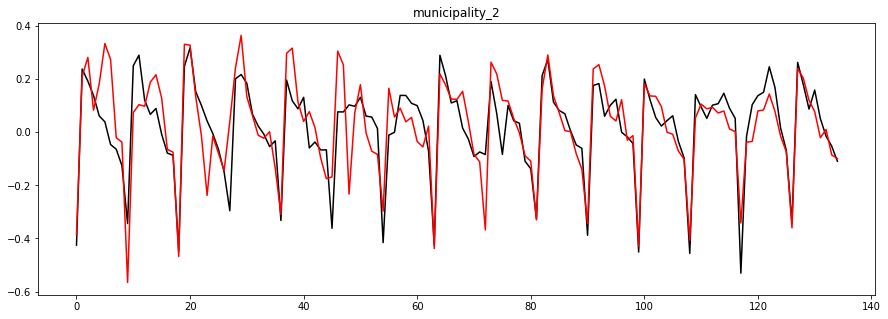

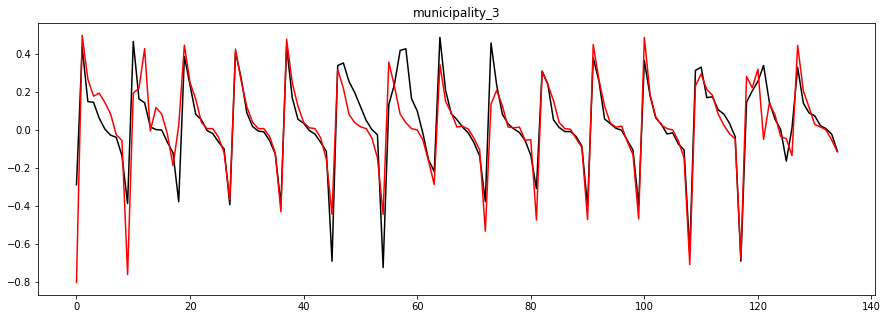

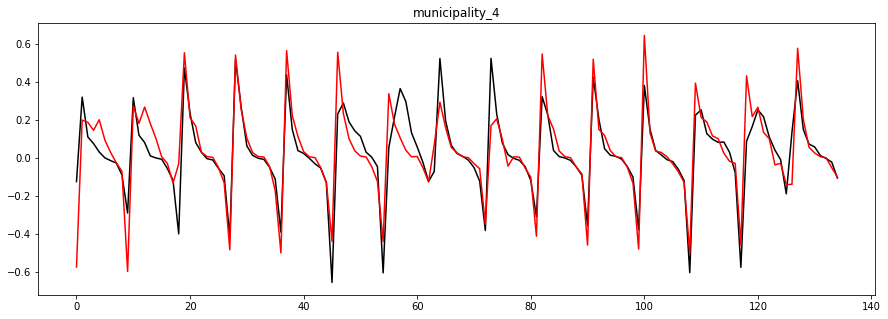

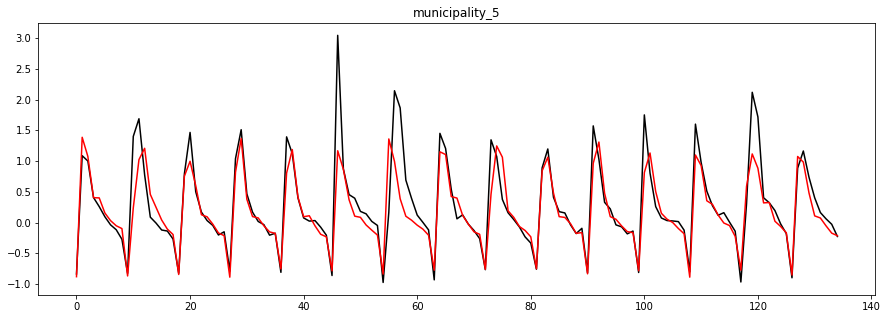

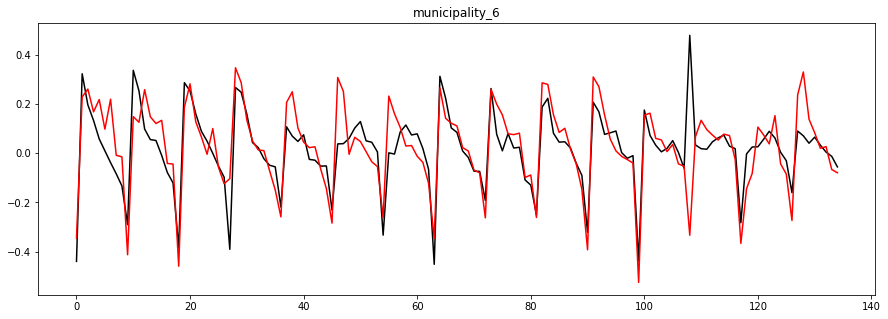

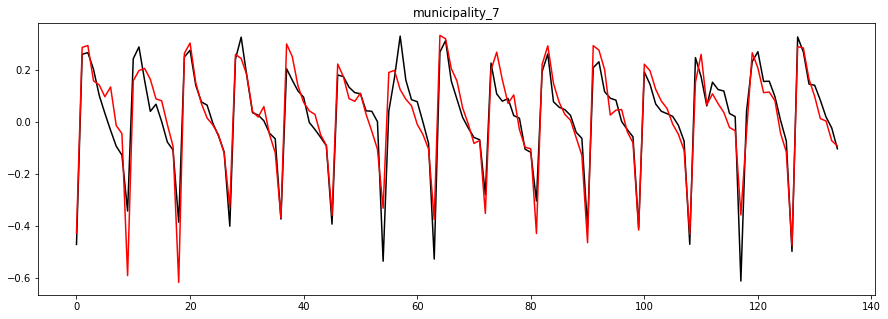

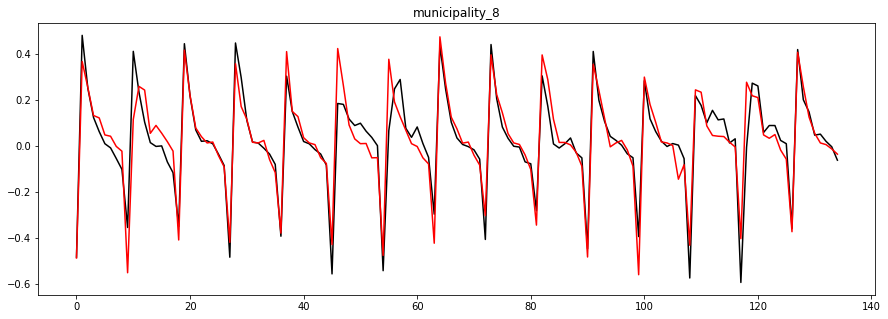

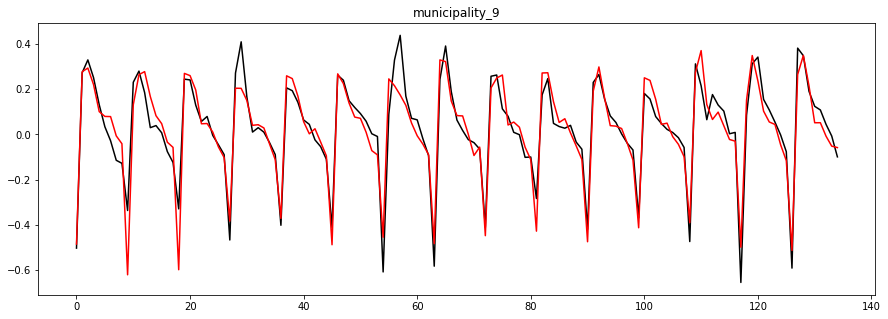

In [316]:
scores_GBR = []
for i in range(10):
    data=munip_df(i)
    data = data.rolling(2,min_periods=1).aggregate(percent_change)
    data.fillna(method="backfill",inplace=True)
    shifted_data = shift_df(data, 9, 21)
    X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
    predictions = train_predict(GBR, X_train,y_train.values.ravel(),X_test)
    score = r2_score(y_test, predictions)
    scores_GBR.append(score)
    plot_loss(y_test, predictions)

In [317]:
scores_GBR

[0.33641295098594226,
 0.8861048595630518,
 0.6324207087794742,
 0.7255306291850798,
 0.6999336684374842,
 0.7456733962080724,
 0.4437581586577499,
 0.8673703086101102,
 0.8586199389620608,
 0.8797483615831252]

In [318]:
sum(scores_GBR)

7.075572980972151

### RandomForestRegressor

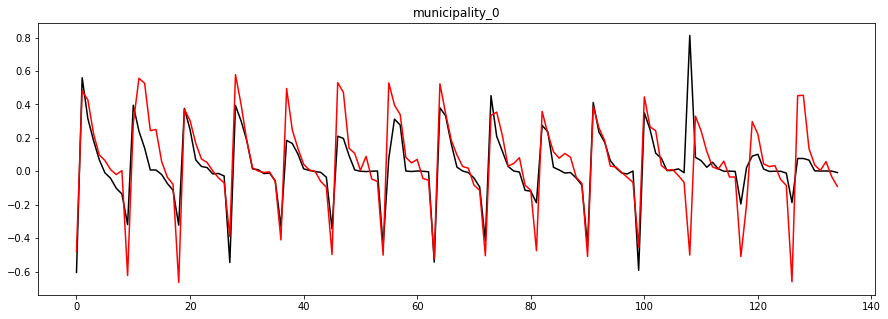

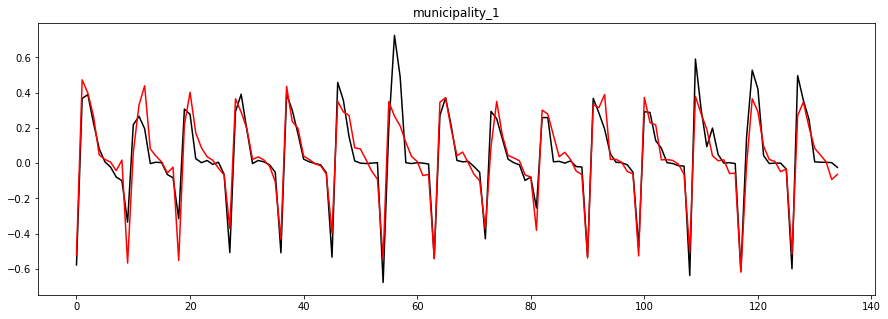

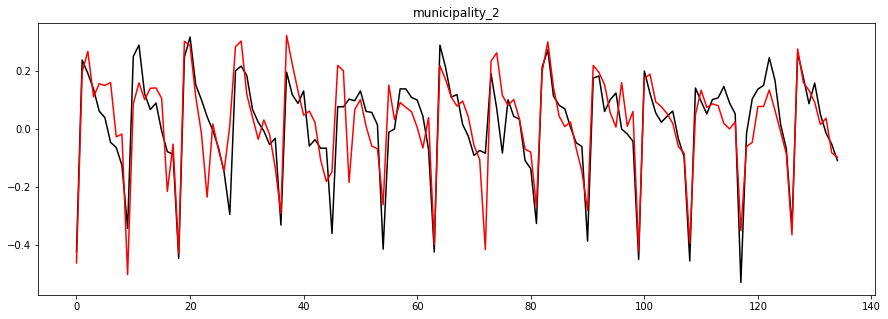

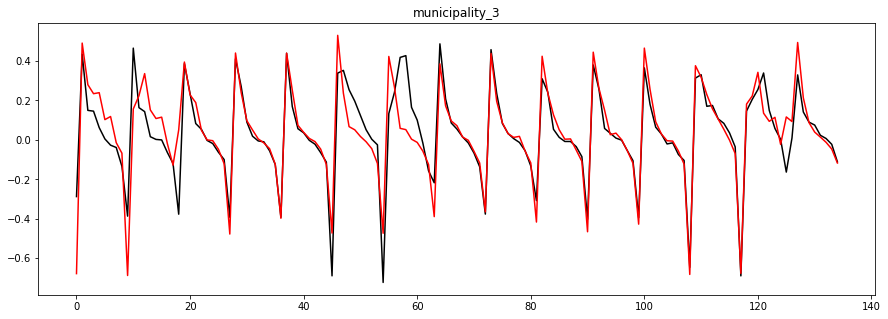

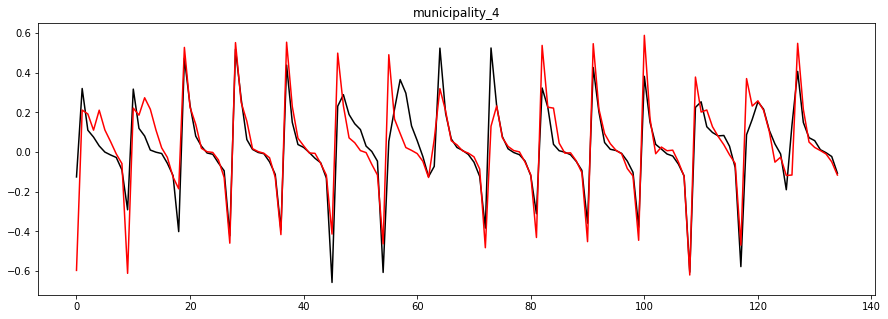

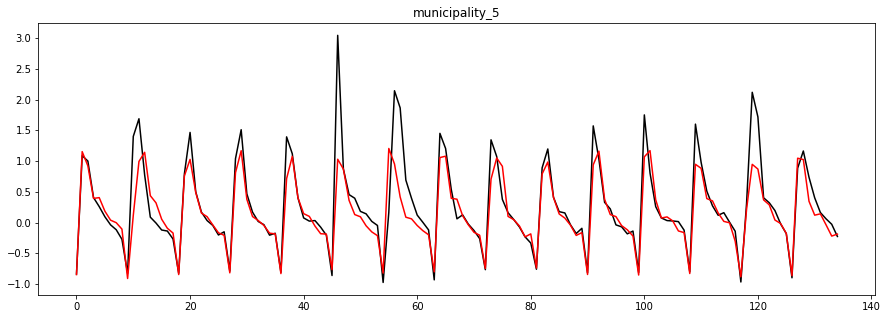

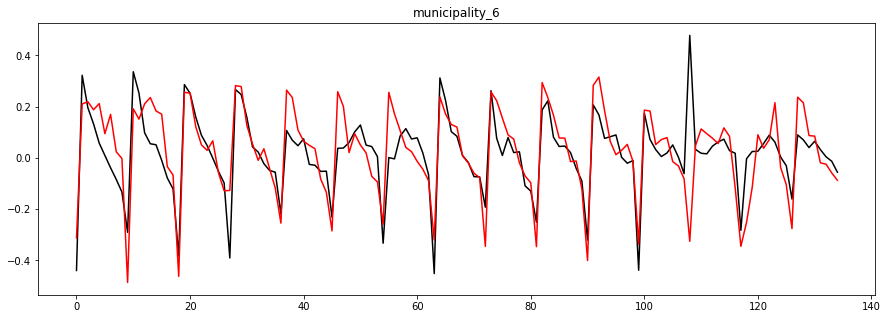

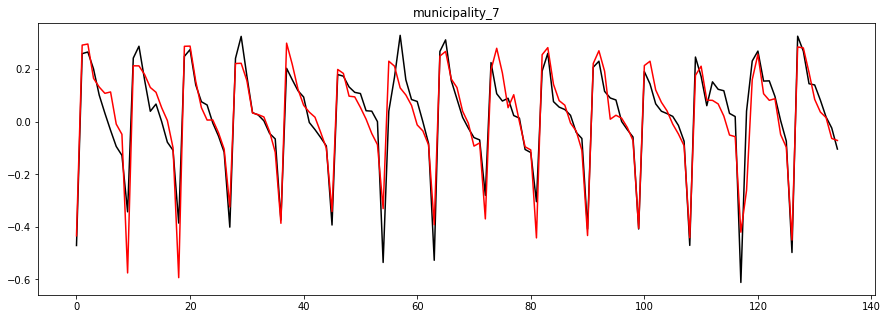

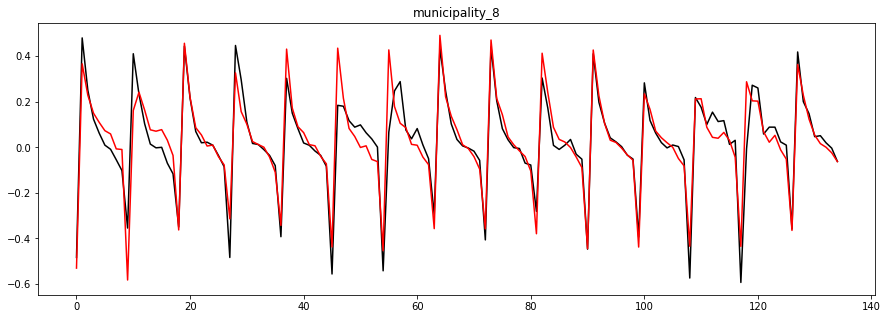

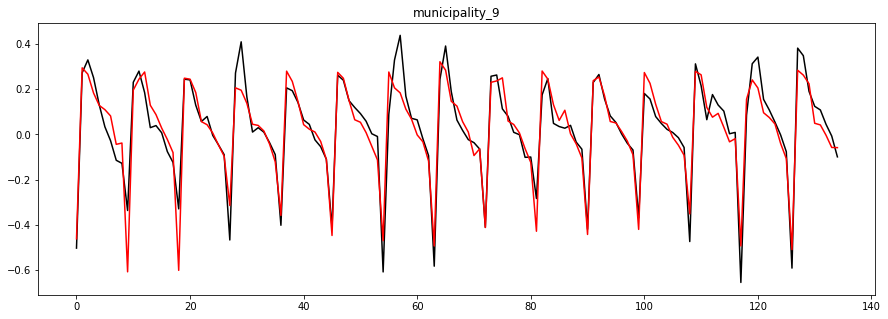

In [320]:
scores_RFR = []
for i in range(10):
    data=munip_df(i)
    data = data.rolling(2,min_periods=1).aggregate(percent_change)
    data.fillna(method="backfill",inplace=True)
    shifted_data = shift_df(data, 9, 21)
    X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
    predictions = train_predict(RFR, X_train,y_train.values.ravel(),X_test)
    score = r2_score(y_test, predictions)
    scores_RFR.append(score)
    plot_loss(y_test, predictions)

In [321]:
scores_RFR

[0.2742758281005965,
 0.8588624284024116,
 0.6939085251223437,
 0.7634648523876564,
 0.7037529675556572,
 0.7429649046198868,
 0.42270918377364397,
 0.8620347375406808,
 0.8612793483625877,
 0.8810046777080918]

In [322]:
sum(scores_RFR)

7.064257453573555

### VotingRegressor

In [323]:
VR = VotingRegressor([('ada', ADA), ('bag', BAG),
                     ('etr', ETR), ('gbr',GBR),
                     ('rfr',RFR)])

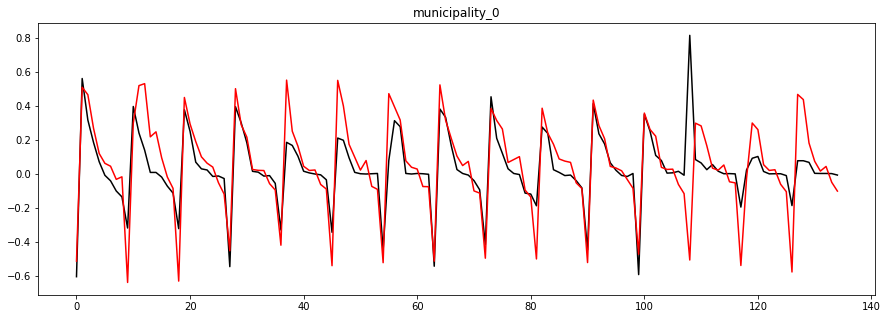

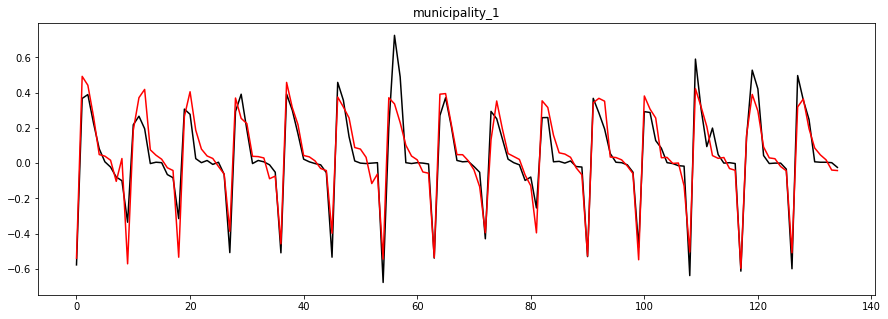

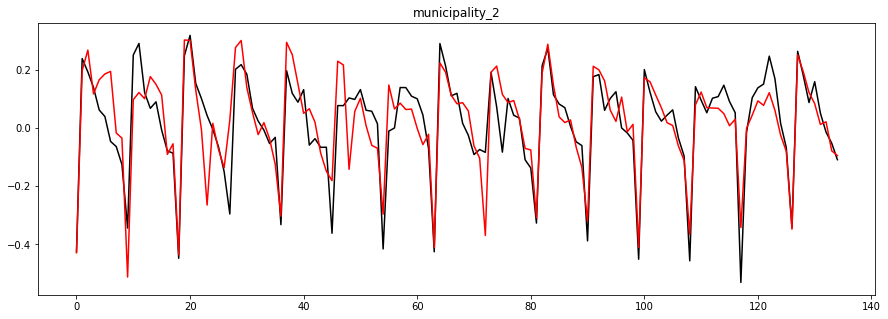

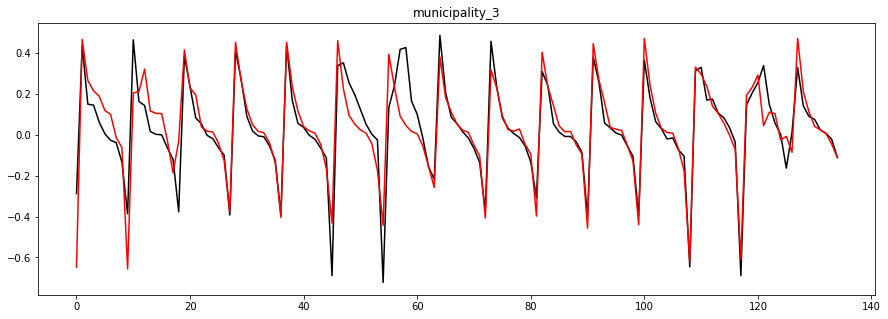

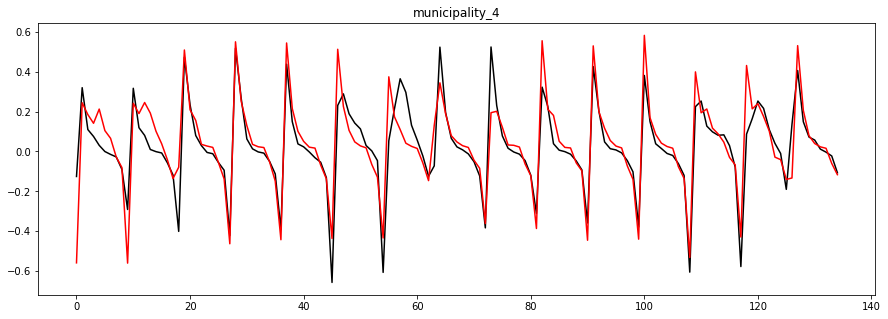

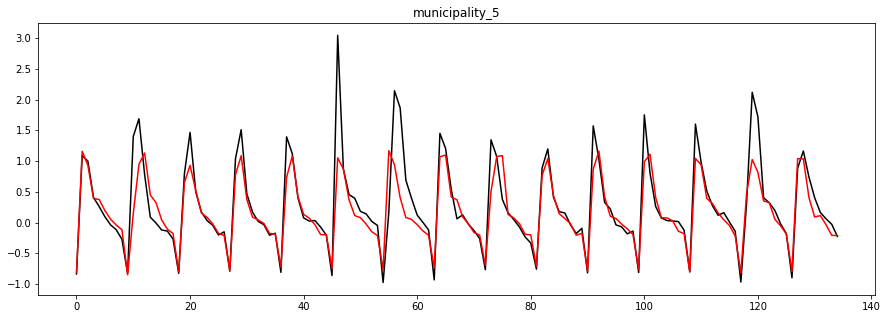

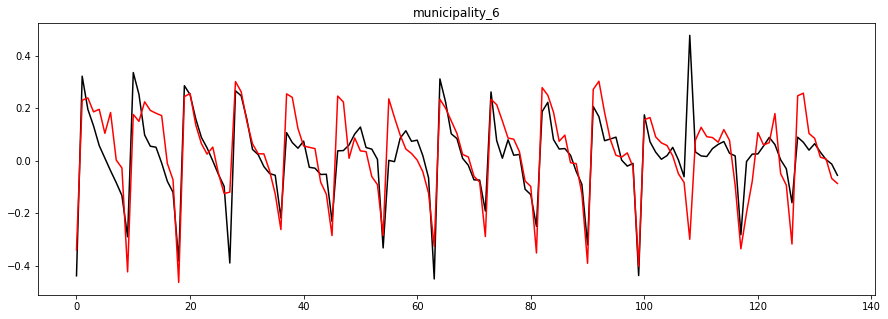

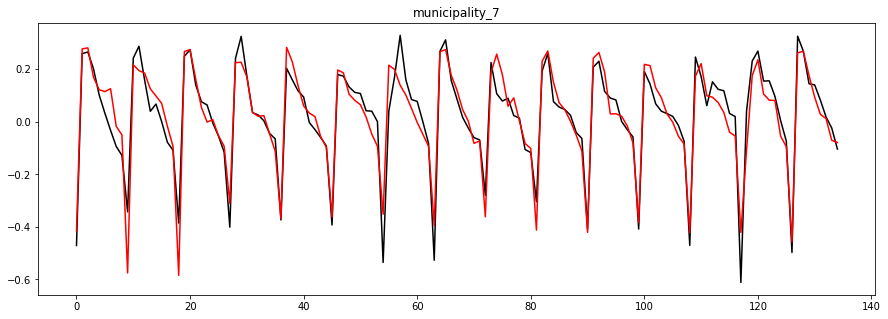

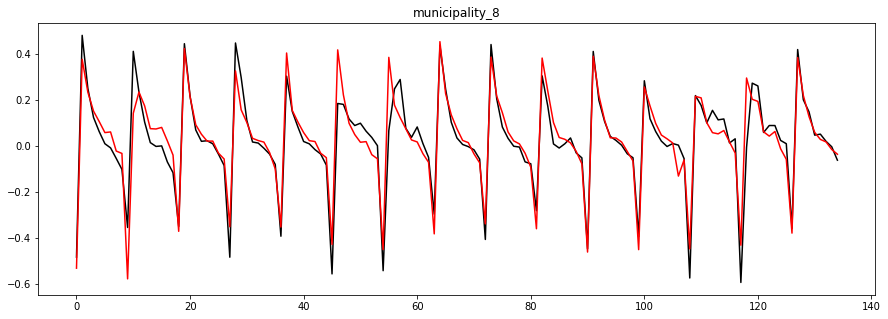

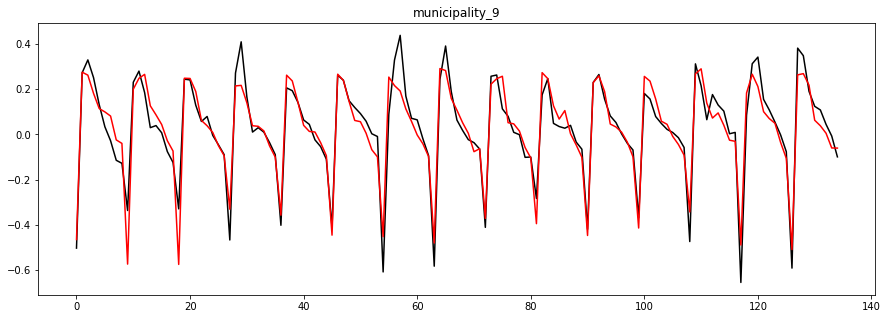

In [324]:
scores_VR = []
for i in range(10):
    data=munip_df(i)
    data = data.rolling(2,min_periods=1).aggregate(percent_change)
    data.fillna(method="backfill",inplace=True)
    shifted_data = shift_df(data, 9, 21)
    X_train, X_test, y_train, y_test = split_train_test(data, shifted_data)
    predictions = train_predict(VR, X_train,y_train.values.ravel(),X_test)
    score = r2_score(y_test, predictions)
    scores_VR.append(score)
    plot_loss(y_test, predictions)

In [325]:
scores_VR

[0.2866456489544633,
 0.8752816130755147,
 0.7249914841603542,
 0.7932945229440586,
 0.7254150420762548,
 0.7355627791805861,
 0.46944488130644346,
 0.8849012025641164,
 0.8718712635763102,
 0.8899726010357483]

In [326]:
sum(scores_VR)

7.2573810388738496

In [374]:
dummy1 = [-1]*10
dummy2 = [-2]*10
dic_scores = {}
all_scores = zip(scores_VR, scores_RFR, scores_GBR,
                 scores_BAG, scores_ET, scores_ADA,
                 scores_ridge_21, scores_ridge_15, 
                 dummy1, dummy2)
for i, (vr, rfr, gbr, bag, et, ada, r21, r15, d1,d2) in enumerate(all_scores):
    max_score = max(vr, rfr, gbr, bag, et, ada, r21, r15, d1,d2)
    dic_scores[i] = max_score

In [375]:
dic_scores

{0: 0.5400020194023614,
 1: 0.8861048595630518,
 2: 0.7714157483937143,
 3: 0.7945043744485137,
 4: 0.7530679561030459,
 5: 0.760397299775239,
 6: 0.4964980843672122,
 7: 0.8870907066604087,
 8: 0.8718712635763102,
 9: 0.8982382034734706}

In [379]:
sum(dic_scores.values())

7.659190515763328

# SUMMARY:

By implementing most suitable algorithms to each municipality, we obtained "good enough" r2 scores. 
"Usage" in;
* "Municipality_0" can be predicted with Ridge regression by 15 days of shifting. R2 score is approx 0.54 which can be interpreted as we can predict the "usage" %54 more accurate than estimating the mean.
* "Municipality_1" can be predicted with GradientBoostingRegressor with an R2 score of approx 0.89 which can be interpreted as we can predict the "usage" %89 more accurate than estimating the mean.
* "Municipality_2", BaggingRegressor with ExtraTreesRegressor as base estimator gives the best R2 score of %77,
* "Municipality_3", ExtraTreesRegressor gives the best R2 score of %80,
* "Municipality_4" BaggingRegressor with ExtraTreesRegressor as base estimator gives the best R2 score of %77,
* "Municipality_5" can be predicted with Ridge regression by 21 days of shifting. R2 score is %76,
* "Municipality_6" VotingRegressor gives the best R2 score of %50,
* "Municipality_7" BaggingRegressor with ExtraTreesRegressor as base estimator gives the best R2 score of %89,
* "Municipality_8" VotingRegressor gives the best R2 score of %87,
* "Municipality_9" BaggingRegressor with ExtraTreesRegressor as base estimator gives the best R2 score of %90.

I would work more on hyperparameter tuning but the score seemed good enough for "bus optimization" of a municipality. 

For more sensitive domains I would use GridsearchCV for better tuning the parameters.

Again with a deeper domain study of the data, I can see that a better interpolation and feature extraction is possible. Also we completely ignored "total capacity" feature, with a better domain knowledge one might detect a causality between usage and capacity. There are some cases that usage is higher than capacity. that might be a guide to some additional features as well.

Finally, I believe a future study can be capable of obtaining an R2 score higher than 0.90 for each municipality, but authorities must decide whether they really need that level of precision or not.


PS: Sorry for the mass, I worked a little bit messy. I usually wrap all my feature extraction and model operations in a pipeline but I thought you may prefer to follow each step. 